# Preprocessing

## Libraries

In [4]:
import pandas as pd
import holidays
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## First preprocessing (Creates Cleaned Data)

In [12]:
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")
    except ValueError:
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            # Return NaT if both formats fail
            print(f"Could not parse date: {date_str}")
            return pd.NaT
        
def clean_data(): 
    # Load the CSV file into a pandas dataframe
    df = pd.read_csv('ColoradoData.csv')

    # Strip extra whitespace from the column names
    df.columns = [col.strip() for col in df.columns]

    # Strip extra whitespace from the date columns
    df['Start_Date___Time'] = df['Start_Date___Time'].str.strip()
    df['End_Date___Time'] = df['End_Date___Time'].str.strip()

    # Now parse the datetime columns using the parse_date function
    df['Start_DateTime'] = df['Start_Date___Time'].apply(parse_date)
    df['End_DateTime'] = df['End_Date___Time'].apply(parse_date)

    # Convert duration columns to timedelta objects
    df['Total_Duration'] = pd.to_timedelta(df['Total_Duration__hh_mm_ss_'])
    df['Charging_Time'] = pd.to_timedelta(df['Charging_Time__hh_mm_ss_'])

    # Convert Energy consumption to a numeric type (handle errors)
    df['Energy_Consumption'] = pd.to_numeric(df['Energy__kWh_'], errors='coerce')

    # Remove the columns that are no longer needed
    df = df.drop(columns=['Start_Date___Time', 'End_Date___Time', 'Total_Duration__hh_mm_ss_',
                'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'ObjectID', 'ObjectId2', 'Start_Time_Zone', 'End_Time_Zone', 'Port_Type', 'GHG_Savings__kg_', 'Gasoline_Savings__gallons_', 'Zip_Postal_Code', 'City'])

    ## More data cleaning
    # Remove rows with negative energy consumption
    df = df[df['Energy_Consumption'] >= 0]

    # Remove rows with missing values
    df = df.dropna()

    # Remove rows with zero charging time
    df = df[df['Charging_Time'] > pd.Timedelta(0)]

    # Remove rows with zero energy consumption
    df = df[df['Energy_Consumption'] > 0]

    # Remove rows with zero total duration
    df = df[df['Total_Duration'] > pd.Timedelta(0)]

    # Remove rows with total duration less than charging time
    df = df[df['Total_Duration'] >= df['Charging_Time']]

    # Sort the data by the Start_DateTime column
    df = df.sort_values(by=['Start_DateTime'], ascending=True)

    # Save the cleaned data to a new CSV file
    df.to_csv('TestDataset/CleanedColoradoData.csv')

    return df

df = clean_data(); 


## Own Resampling (For aggregating all stations into one)

In [13]:
data = pd.read_csv('TestDataset/CleanedColoradoData.csv')

def preprocess_dataset(data): 
    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['End_Time'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    # Convert string dates to datetime objects for comparison
    start_date = pd.to_datetime('2021-11-30')
    end_date = pd.to_datetime('2023-11-30')

    # Take data from 30/11/2021 to 30/11/2023
    data = data[(data['Start_DateTime'] >= start_date) & (data['Start_DateTime'] <= end_date)].copy()

    # Calculate the end of the charging interval as start time + charging time
    data['Charging_EndTime'] = data['Start_DateTime'] + data['Charging_Time']

    # Sort the data by the Start_DateTime column
    data = data.sort_values(by=['Start_DateTime'], ascending=True)
    
    # Remove duplicates 
    data = data.drop_duplicates(
        subset=['Start_DateTime', 'Charging_Time', 'Energy_Consumption'])

    # Split the session into hourly intervals
    hourly_rows = [] 

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows(): 
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate hourly intervals
        hourly_intervals = pd.date_range(start=start.floor('h'), end=end.ceil('h'), freq='h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    # Create a new dataframe from the hourly intervals
    hourly_df = pd.DataFrame(hourly_rows)

    # Aggregate the hourly intervals
    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime( hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='h')


    # Reindex the hourly data to include all hours in the range
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    # Return the hourly data
    return hourly_df


hourly_df = preprocess_dataset(data=data)
print(hourly_df.info())

                     Energy_Consumption  Session_Count
2021-11-30 00:00:00            3.545981              1
2021-11-30 01:00:00            4.342017              1
2021-11-30 02:00:00            0.316002              1
2021-11-30 03:00:00            0.000000              0
2021-11-30 04:00:00            0.000000              0
2021-11-30 05:00:00            0.000000              0
2021-11-30 06:00:00            0.000000              0
2021-11-30 07:00:00            7.807448              3
2021-11-30 08:00:00           18.809152              8
2021-11-30 09:00:00           28.035011              7
2021-11-30 10:00:00           20.922703              6
2021-11-30 11:00:00           19.262604              6
2021-11-30 12:00:00           16.550301              9
2021-11-30 13:00:00           14.436643              6
2021-11-30 14:00:00            6.560589              3
2021-11-30 15:00:00           17.672917              3
2021-11-30 16:00:00           11.954008              5
2021-11-30

## Own Resampling (For aggregating each station has it own charging station)

## Features
### Date features (Day, Hour (Cos, Sinus), holiday, weekend/weekday), roll-back (1 hour, 6 hours, 1 day, 1 week), rolling-average 

In [5]:
def add_features(hourly_df, start_date, end_date): 
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day'] >= 6) & (hourly_df['Hour_of_Day'] <= 18)


  # Add holiday
  us_holidays = holidays.US(years=range(start_date.year, end_date.year + 1))
  hourly_df['IsHoliday'] = hourly_df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)


  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(2 * np.pi * hourly_df['Month_of_Year'] / 12)


  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 
                     7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)


  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  ## Lag features
  #1h 
  hourly_df['Energy_Consumption_1h'] = hourly_df['Energy_Consumption'].shift(1)

  #6h 
  hourly_df['Energy_Consumption_6h'] = hourly_df['Energy_Consumption'].shift(6)

  #12h
  hourly_df['Energy_Consumption_12h'] = hourly_df['Energy_Consumption'].shift(12)

  #24h
  hourly_df['Energy_Consumption_24h'] = hourly_df['Energy_Consumption'].shift(24)

  # 1 week 
  hourly_df['Energy_Consumption_1w'] = hourly_df['Energy_Consumption'].shift(24*7)

  ## Rolling average 
  # 24h
  hourly_df['Energy_Consumption_rolling'] = hourly_df['Energy_Consumption'].rolling(window=24).mean() 
  
  return hourly_df

# Convert string dates to datetime objects for comparison
start_date = pd.to_datetime('2022-11-30')
end_date = pd.to_datetime('2023-11-30')

hourly_df = add_features(hourly_df, start_date, end_date)

print(hourly_df.info())

#print(hourly_df.head())

# Save the final dataset to a new CSV file
hourly_df.to_csv('TestDataset/FinalColoradoData.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2021-11-30 00:00:00 to 2023-11-30 23:00:00
Freq: h
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Energy_Consumption          17544 non-null  float64
 1   Session_Count               17544 non-null  int64  
 2   Day_of_Week                 17544 non-null  int32  
 3   Hour_of_Day                 17544 non-null  int32  
 4   Month_of_Year               17544 non-null  int32  
 5   Year                        17544 non-null  int32  
 6   Day/Night                   17544 non-null  bool   
 7   IsHoliday                   17544 non-null  int64  
 8   Weekend                     17544 non-null  int64  
 9   HourSin                     17544 non-null  float64
 10  HourCos                     17544 non-null  float64
 11  DayOfWeekSin                17544 non-null  float64
 12  DayOfWeekCos                17544 non-null  f

## Plotting Final dataset

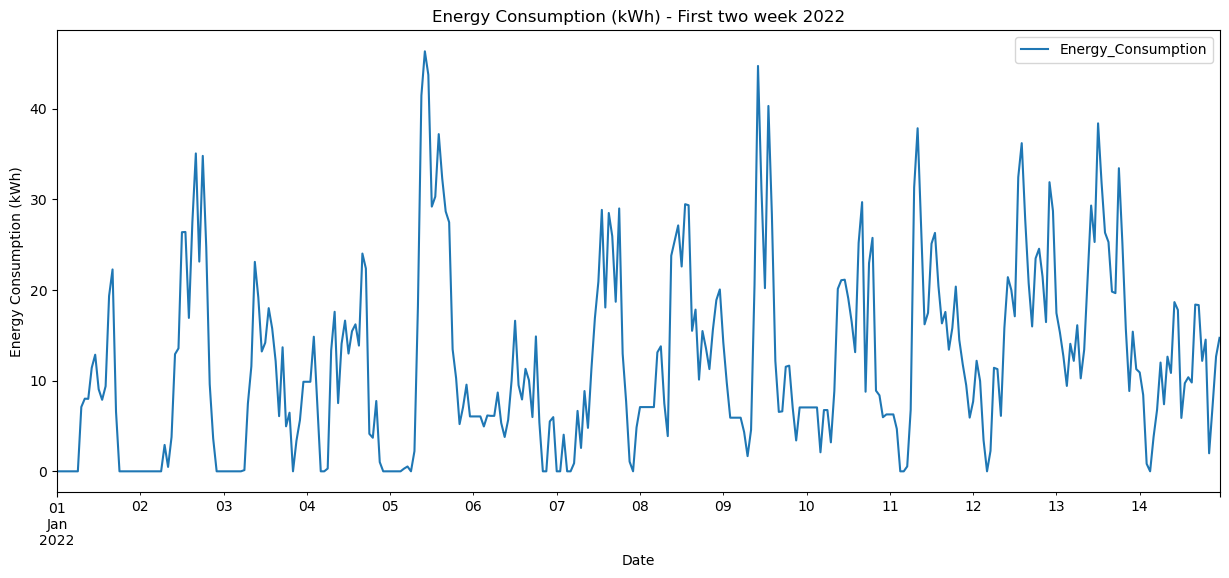

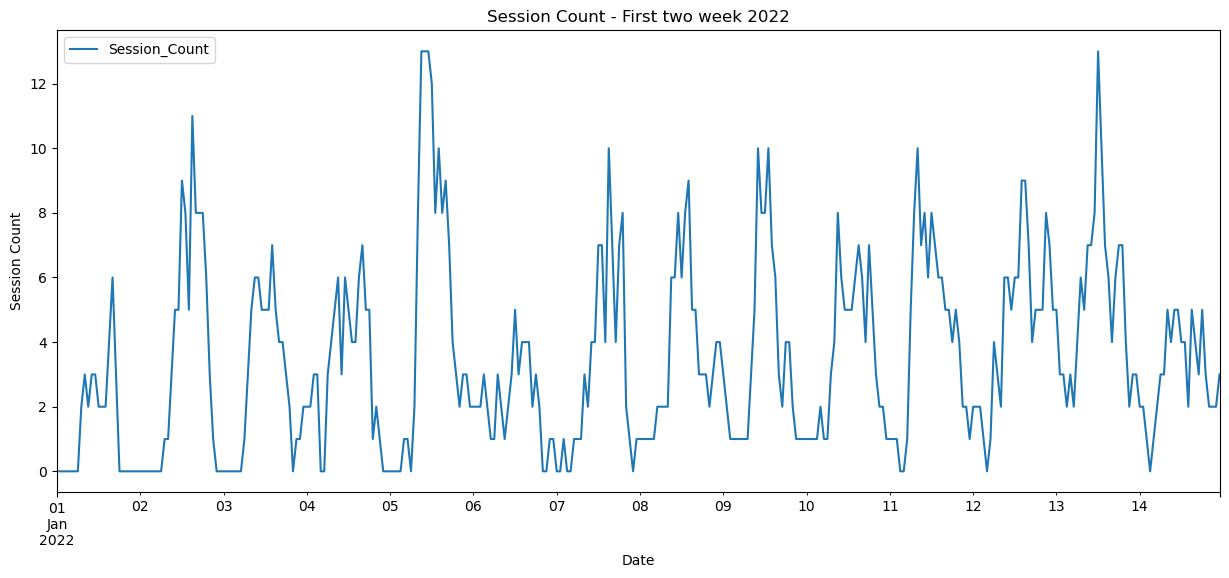

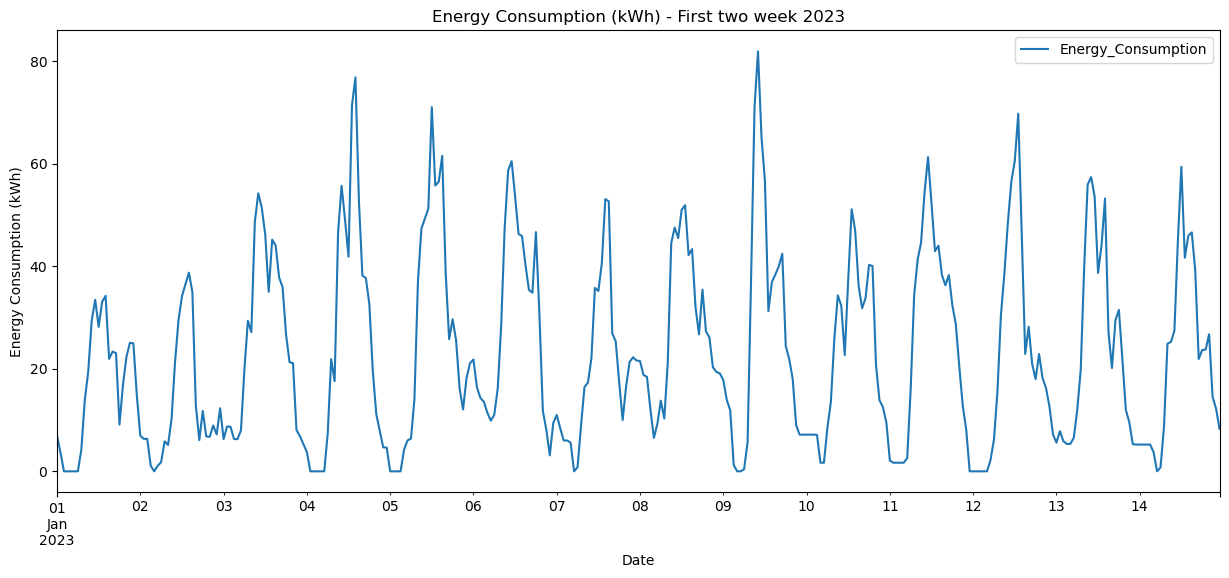

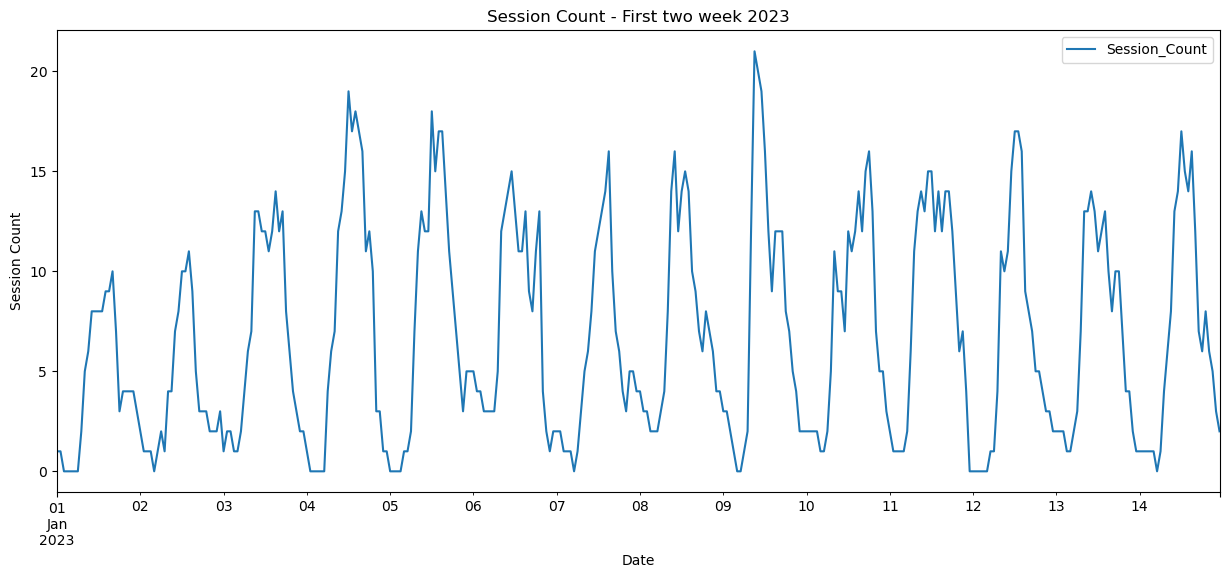

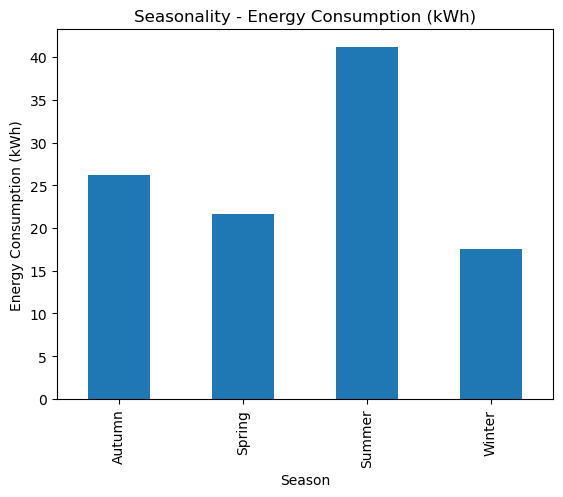

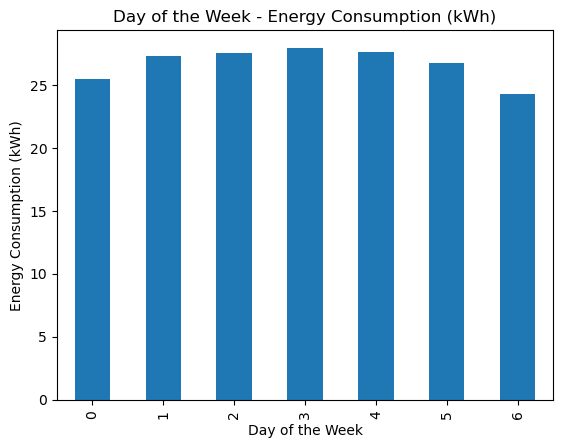

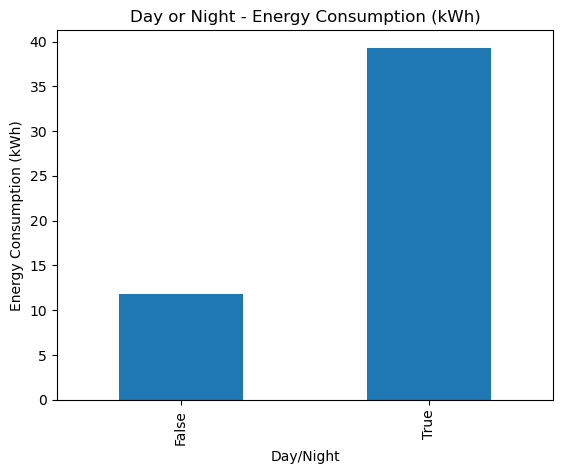

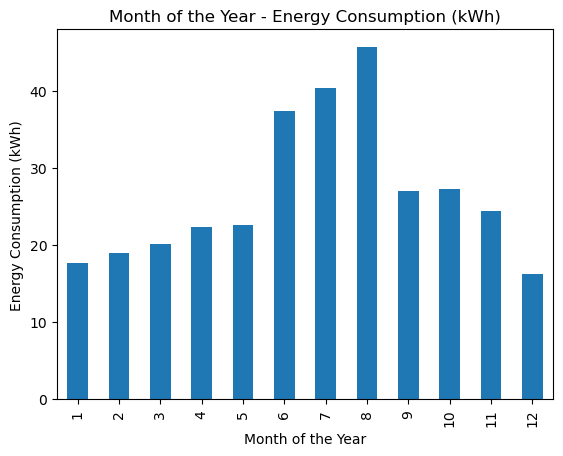

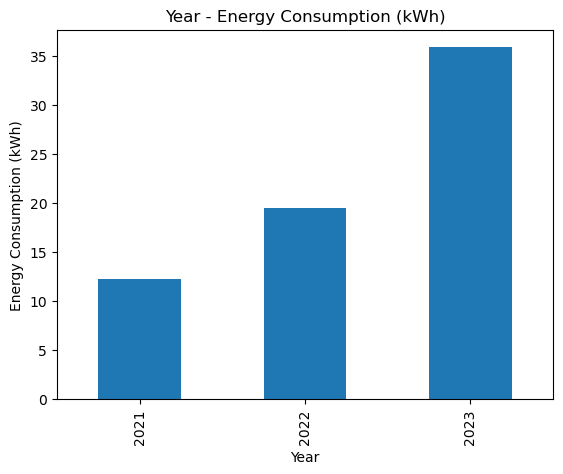

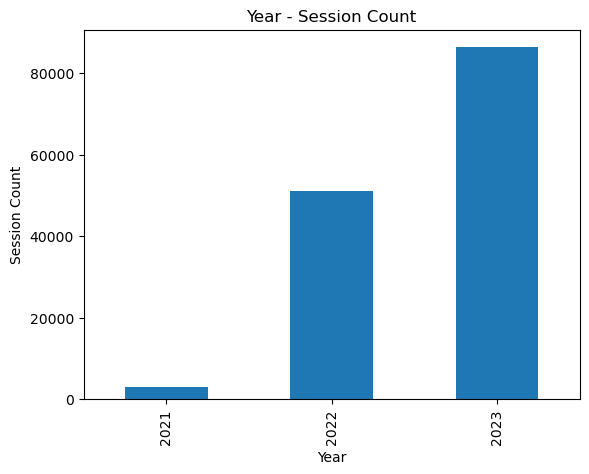

<Axes: title={'center': 'Month - Session Count'}, xlabel='Month', ylabel='Session Count'>

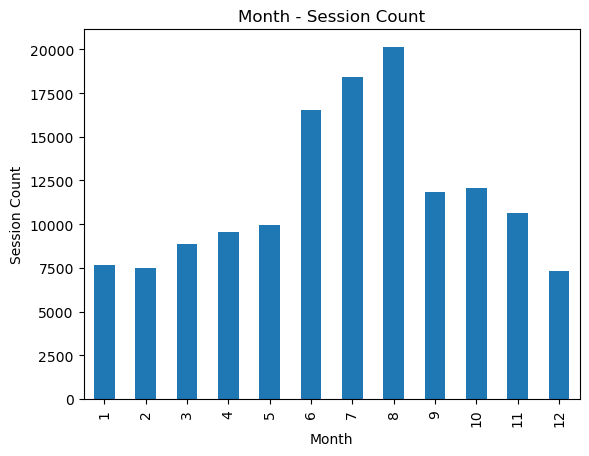

In [6]:
## Plotting the final dataset
# Plot first two weeks
hourly_df.loc['2022-01-01':'2022-01-14'].plot(y='Energy_Consumption', title='Energy Consumption (kWh) - First two week 2022',
                                              figsize=(15, 6), xlabel='Date', ylabel='Energy Consumption (kWh)')
plt.show()

# PLot the session count for the first two weeks in 2022
hourly_df.loc['2022-01-01':'2022-01-14'].plot(y='Session_Count', title='Session Count - First two week 2022',
                                              figsize=(15, 6), xlabel='Date', ylabel='Session Count')
plt.show()


# Plot first two weeks in 2023
hourly_df.loc['2023-01-01':'2023-01-14'].plot(y='Energy_Consumption', title='Energy Consumption (kWh) - First two week 2023',
                                              figsize=(15, 6), xlabel='Date', ylabel='Energy Consumption (kWh)')
plt.show()


# PLot the session count for the first two weeks in 2023
hourly_df.loc['2023-01-01':'2023-01-14'].plot(y='Session_Count', title='Session Count - First two week 2023',
                                              figsize=(15, 6), xlabel='Date', ylabel='Session Count')
plt.show()

# Plot seasonality
hourly_df.groupby('Season')['Energy_Consumption'].mean().plot(kind='bar', title='Seasonality - Energy Consumption (kWh)',
                                                              xlabel='Season', ylabel='Energy Consumption (kWh)')
plt.show()


# Day of the week
hourly_df.groupby('Day_of_Week')['Energy_Consumption'].mean().plot(kind='bar', title='Day of the Week - Energy Consumption (kWh)',
                                                                   xlabel='Day of the Week', ylabel='Energy Consumption (kWh)')
plt.show()

# Day/Night
hourly_df.groupby('Day/Night')['Energy_Consumption'].mean().plot(kind='bar', title='Day or Night - Energy Consumption (kWh)',
                                                                 xlabel='Day/Night', ylabel='Energy Consumption (kWh)')
plt.show()

# Month of the year
hourly_df.groupby('Month_of_Year')['Energy_Consumption'].mean().plot(kind='bar', title='Month of the Year - Energy Consumption (kWh)',
                                                                     xlabel='Month of the Year', ylabel='Energy Consumption (kWh)', x='Month')
plt.show()

# Plot for year
hourly_df.groupby('Year')['Energy_Consumption'].mean().plot(kind='bar', title='Year - Energy Consumption (kWh)',
                                                            xlabel='Year', ylabel='Energy Consumption (kWh)')
plt.show()

# Session count for year
hourly_df.groupby('Year')['Session_Count'].sum().plot(kind='bar', title='Year - Session Count',
                                                      xlabel='Year', ylabel='Session Count')
plt.show()

# session count for month
hourly_df.groupby('Month_of_Year')['Session_Count'].sum().plot(kind='bar', title='Month - Session Count',
                                                               xlabel='Month', ylabel='Session Count')


